In [47]:

from importlib import reload
import synapse_selector.utils.failure_rate
reload(synapse_selector.utils.failure_rate)
from synapse_selector.utils.failure_rate import failure_rate
import pandas as pd
import numpy as np

In [48]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from silx.io.dictdump import dicttoh5, h5todict
import numpy as np

import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
#from sklearn.model_selection import train_test_split
if torch.cuda.is_available():
    print('GPU ready')
else:
    print('Warning: only CPU found')

In [49]:
def parse_h5_file(path: str) -> tuple[dict,int]:
    traces = h5todict(path)
    peak_position = int(traces['peak_frame'])
    return traces, peak_position

def random_trace(traces: dict) -> list[float]:
    # choose random pot
    pot_keys = [*traces.keys()]
    pot_keys.remove('peak_frame')
    # choose random trace from random pot
    pot_key = np.random.choice(pot_keys)
    trace_key = np.random.choice([*traces[pot_key].keys()])
    return traces[pot_key][trace_key]

def scale_array(arr, min_val, max_val):
    min_arr, max_arr = np.min(arr), np.max(arr)
    scaled_arr = (arr - min_arr) / (max_arr - min_arr) * (max_val - min_val) + min_val
    return scaled_arr

def add_trace(traces: dict,
              trace: np.ndarray,
              # position of the peak inside the whole trace
              position: int,
              # position of the peak inside the peak trace
              peak_position: int,
              intensity_peaks: list[float]) -> np.ndarray:
    # pick a random trace from dict
    selected_trace = random_trace(traces)
    # draw a random scale factor for the trace peak and scale it
    scale_factor = np.random.uniform(intensity_peaks[0], intensity_peaks[1])
    scaled_trace = scale_array(selected_trace, np.random.uniform(-0.05,0.05), scale_factor)
    frames_after = len(scaled_trace) - (peak_position+1)
    # if the actual peak timepoint of the peak trace would be outside the boundaries
    # e.g. position = 2 & peak_position = 7
    if position - peak_position < 0:
        # trim left side
        frames_to_trim = peak_position - position
        scaled_trace = scaled_trace[frames_to_trim:]
        pad_right = len(trace) - len(scaled_trace)
        scaled_trace = np.pad(scaled_trace, (0, pad_right), constant_values=(0, 0))
        return np.add(trace, scaled_trace)
    # if the actual peak timepoint would be outside the boundaries
    elif position + frames_after >= len(trace):
        # trim right side
        frames_to_trim = (len(trace) - position) + peak_position
        scaled_trace = scaled_trace[:frames_to_trim]
        pad_left = len(trace) - len(scaled_trace)
        scaled_trace = np.pad(scaled_trace, (pad_left, 0), constant_values=(0, 0))
        return np.add(trace,scaled_trace)
    # no trimming
    pad_left = position - peak_position
    pad_right = len(trace) - (position + frames_after) - 1
    scaled_trace = np.pad(scaled_trace, (pad_left, pad_right), constant_values=(0, 0))
    return np.add(trace,scaled_trace)

def validate_peak_positions(trace: np.ndarray,
                            peaks: list[int]) -> list[int]:
    '''
    Adding multiple peaks in close proximity might result in shifted peak positions. 
    This function checks whether the peak is offset by 1 and corrects for this.
    '''
    validated_peaks = []
    for peak in peaks:
        lower_border = max(0,peak-1)
        upper_border = min(len(trace),peak+2)
        validated_peaks.append(np.argmax(trace[lower_border:upper_border])+lower_border)
    return validated_peaks

def add_noise(trace: np.ndarray,
              peaks: list[int],
              std_noise: float) -> np.ndarray:
    noise_template = np.random.normal(0, std_noise, len(trace))
    trace_with_noise = np.add(trace, noise_template)
    for peak_pos in peaks:
        if peak_pos == 0:
            if trace_with_noise[peak_pos] < trace_with_noise[peak_pos + 1]:
                noise_template[peak_pos] = 0
                noise_template[peak_pos +1 ] = 0
        elif peak_pos + 1 == len(trace):
            if trace_with_noise[peak_pos] < trace_with_noise[peak_pos - 1]:
                noise_template[peak_pos] = 0
                noise_template[peak_pos - 1] = 0
        elif (trace_with_noise[peak_pos] < trace_with_noise[peak_pos + 1]) or (trace_with_noise[peak_pos] < trace_with_noise[peak_pos - 1]):
            noise_template[peak_pos - 1] = 0
            noise_template[peak_pos] = 0
            noise_template[peak_pos + 1] = 0
        else:
            continue
        trace_with_noise = np.add(trace, noise_template)
    return trace_with_noise
            

def simulate_trace(traces: dict,
                   trace_length: int,
                   std_noise: float,
                   min_dist_peaks: int,
                   template_peak_timepoint: int,
                   max_peaks: int = 10,
                   intensity_peaks: list[float] = [1.2,15]) -> tuple[np.ndarray,list[int]]:
    max_peaks_possible = trace_length // (min_dist_peaks+1)
    if max_peaks >= max_peaks_possible:
        raise ValueError(f'At most {max_peaks_possible} for trace length {trace_length}. You selected {max_peaks}.')
    # buffer for simulated trace
    trace = np.zeros(trace_length)
    # get peak parameters
    num_peaks = np.random.randint(0,max_peaks)
    peak_positions = []
    possible_peak_positions = np.arange(trace_length)
    
    for _ in range(num_peaks):
        if len(possible_peak_positions) == 0:
            print(f'Restarted trace simulation because no possible peak position was left. If this happend more often, consider using a lower number of max_peaks (currently: {max_peaks}) or a longer simulation length (currently: {trace_length}).')
            return simulate_trace(traces, trace_length, std_noise, min_dist_peaks, template_peak_timepoint, max_peaks, intensity_peaks)
        # choose a random position for the peak
        peak_positions.append(np.random.choice(possible_peak_positions))
        # remove surrounding entries from possible peak positions
        idx_peak_position = np.where(possible_peak_positions == peak_positions[-1])[0][0]
        idx_start = max(0, idx_peak_position - min_dist_peaks)
        idx_end = min(trace_length, idx_peak_position + min_dist_peaks)
        possible_peak_positions = np.concatenate((possible_peak_positions[:idx_start], possible_peak_positions[idx_end + 1:]))
        # add a peak trace to that specific peak position
        trace = add_trace(traces, trace, peak_positions[-1], template_peak_timepoint, intensity_peaks)
    # increase baseline to 1
    trace = np.add(trace,np.ones(trace_length))
    # validate peak positions
    peak_positions = validate_peak_positions(trace, peak_positions)
    return add_noise(trace, peak_positions, std_noise), peak_positions
    

In [50]:
traces, peak_position = parse_h5_file("/Users/stephanweissbach/Desktop/traces.h5")

In [51]:
def sliding_window(data, window_size, overlap_percent):
    stride = int(window_size * (1 - overlap_percent))

    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        window = data[i:i+window_size]
        windows.append(window)
    return torch.stack(windows)

In [52]:
num_samples = 1000
input_length = 10_000
window_length = 50
windows_per_sample = input_length // window_length
std_center = 0.09
std_scale = 0.0125
max_peaks = 1000

data = torch.zeros((num_samples * windows_per_sample, 1, window_length), dtype=torch.float32)
labels = torch.zeros((num_samples * windows_per_sample), window_length, dtype=torch.float32)

for idx in range(num_samples):
    offset = idx * windows_per_sample
    std = abs(np.random.normal(std_center, std_scale))
    trace, peak_positions = simulate_trace(traces, input_length, std, 2, peak_position, max_peaks, [0.4, 3])
    trace_tensor = torch.tensor(trace)
    traces_sliding = sliding_window(trace_tensor, window_length, 0)

    labels_trace = torch.zeros(input_length)

    # create labels
    for peak in peak_positions:
        labels_trace[peak] = 1

    labels_sliding = sliding_window(labels_trace, window_length, 0)
    
    for trace_idx, trace_sliding in enumerate(traces_sliding): 
        data[offset + trace_idx] = trace_sliding
    
    for label_idx, label_sliding in enumerate(labels_sliding): 
        labels[offset + label_idx] = label_sliding

In [53]:
import torch.nn.functional as F

class PeakDetectionModel_convout(pl.LightningModule):
    def __init__(self):
        super(PeakDetectionModel_convout, self).__init__()

        # 1D Convolution layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm1d(32)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(128)

        # Max pooling layers
        self.pool = nn.MaxPool1d(kernel_size=1, stride=1)

        # Output convolutional layer with 1 channel
        self.output_conv = nn.Conv1d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        # Input shape: (batch_size, 1, sequence_length)

        # Convolutional layers with batch normalization and relu activation
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)

        # Apply output convolutional layer with 1 channel
        x = self.output_conv(x)

        # Apply sigmoid activation for peak detection
        x = torch.sigmoid(x)

        return x[:, -1, :]  # Squeeze the channel dimension for a 1D output

    def training_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self(data)
        loss = F.binary_cross_entropy(outputs, targets)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self(data)
        loss = F.binary_cross_entropy(outputs, targets)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [54]:
from synapse_selector.detection.model_wraper import torch_cnn_model

In [55]:
model = torch_cnn_model()
model.load_weights('/Users/stephanweissbach/.synapse_selector_modelzoo/peak_detection-conv_output.pt')

In [73]:
data_abs = pd.read_csv('/Users/stephanweissbach/Desktop/results/Coverslip1_evoked_spontan_R5_traces_abs.csv')

In [57]:
pred = model.predict(data['1'].to_numpy())

[3.6428869e-04 1.1108328e-02 3.6337916e-03 ... 1.8919488e-23 1.5259219e-17
 4.0850049e-13]


In [58]:
probabilities = model.preds

In [59]:
y_data = data['1'].to_numpy()
x_data = np.arange(len(y_data))

In [60]:
plot_dataframe = pd.DataFrame({
    'x' : x_data,
    'y' : y_data,
    'probability': probabilities
})

In [61]:
plot_dataframe

,x,y,probability
0,0,1.199428,3.642887e-04
1,1,1.249469,1.110833e-02
2,2,1.242137,3.633792e-03
3,3,1.236088,2.594816e-04
4,4,1.206027,1.119071e-04
...,...,...,...
2995,2995,0.754197,2.433991e-26
2996,2996,0.731101,7.922846e-25
2997,2997,0.679961,1.891949e-23
2998,2998,0.751448,1.525922e-17


In [72]:
import plotly.express as px

fig = px.line(plot_dataframe,x='x',y='y',hover_data='probability',template="plotly_white")
fig.update_layout(
            xaxis=dict(rangeslider=dict(visible=True), type="linear"),
        )
fig.add_hline(y=2, line_color="red", line_dash="dash")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[3.6428869e-04],
                                   [1.1108328e-02],
                                   [3.6337916e-03],
                                   ...,
                                   [1.8919488e-23],
                                   [1.5259219e-17],
                                   [4.0850049e-13]], dtype=float32),
              'hovertemplate': 'x=%{x}<br>y=%{y}<br>probability=%{customdata[0]}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([   0,    1,    2, ..., 2997, 2998, 2999]),
              'xaxis': 'x',
              'y': array([1.19942848, 1.2494689 , 1.24213697, ..., 0.67996128, 0.75144759,
                          0.73421756]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': 'red', 'dash': 'dash'},
                           'type': 'line',
                           'x0': 0,
                           'x1': 1,
                           'xref': 'x domain',
                           'y0': 2,
                           'y1': 2,
                           'yref': 'y'}],
               'template': '...',
               'xaxis': {'anchor': 'y',
                         'domain': [0.0, 1.0],
                         'rangeslider': {'visible': True},
                         'title': {'text': 'x'},
                         'type': 'linear'},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

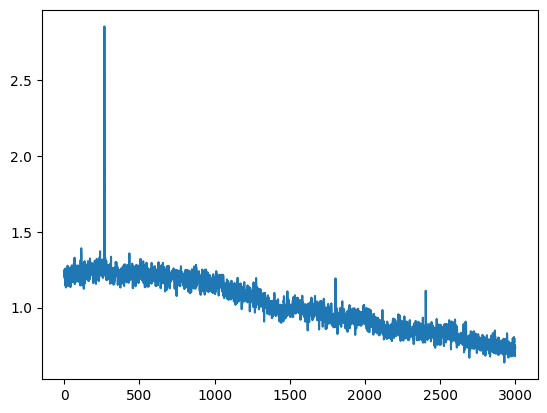

In [86]:
plt.plot(data['1'])

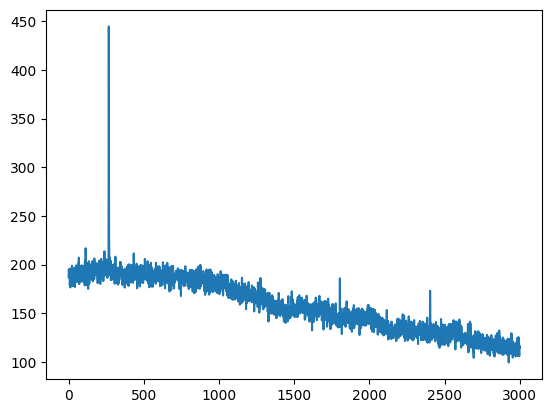

In [85]:
plt.plot(data_abs['1'])

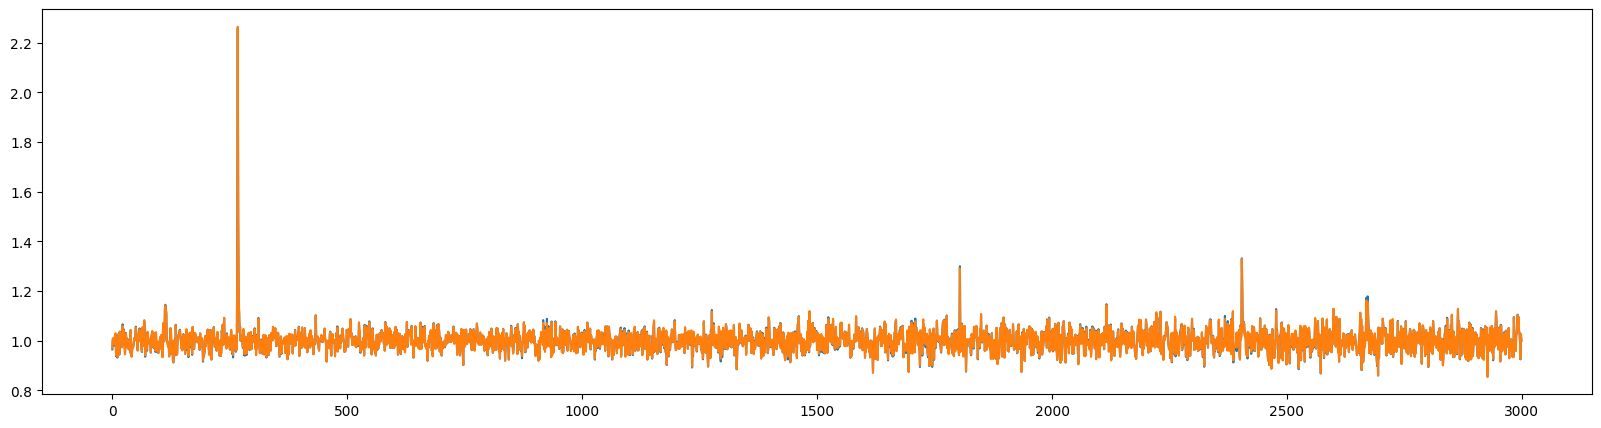

In [100]:
from importlib import reload
import synapse_selector.utils.normalization  # Replace 'your_module' with the actual name of your module

reload(synapse_selector.utils.normalization)

from synapse_selector.utils.normalization import sliding_window_normalization
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(sliding_window_normalization(sliding_window_normalization(data_abs['1'].to_numpy(),window_size=50)))
ax.plot(sliding_window_normalization(data_abs['1'].to_numpy(),window_size=50))

#ax.plot(sliding_window_normalization(data_abs['1'].to_numpy(),False),label='mean')

In [93]:
model.predict(sliding_window_normalization(data_abs['1'].to_numpy(),False,window_size=50),threshold=0.05)

[5.1514668e-09 2.4777036e-10 1.7499908e-11 ... 9.2923040e-16 9.8693928e-11
 9.3326880e-10]


[267]

In [103]:
np.any([])

False